Install relevant library

In [3]:
 #pip install scikit-learn numpy pandas matplotlib seaborn

Import Libraries

In [78]:
import numpy as np
import pandas as pd
import mlflow
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report

#Plotting Libs
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

***Data Loading & Previewing***

In [16]:
#Read the raw data
df=pd.read_csv(r"C:\git\python\projects\bank_affluent_classif\data\bank_customer_data.csv")
LABEL_COL = 'C_seg'

In [37]:
# Quick Data Preview
print('No of Datapoints --> ',len(df))
print('################## Dataset Preview #########################')
df.head()

No of Datapoints -->  66083
################## Dataset Preview #########################


,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,...,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,1443,65,Masters,EXECUTIVE CONDOMINIUM,19250.0,6.0,PMEB,3,8.0,6896.91,...,0.00,0.0,13.233333,0.00,0.00,0.000000,0.00,0.0,34500.0,AFFLUENT
1,1559,86,O-Levels,PRIVATE CONDOMINIUM,99018.0,2.0,PMEB,4,13.0,51714.78,...,0.00,0.0,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,1913,69,A-Levels,0,10155.0,3.0,PMEB,4,1.0,5420.09,...,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,2032,70,0,0,21863.0,2.0,RETIREE,3,1.0,13596.65,...,33902.58,1.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.0,AFFLUENT
4,2048,72,O-Levels,EXECUTIVE CONDOMINIUM,10641.0,0.0,BLUE COLLAR,4,2.0,51639.18,...,15619.29,1.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.0,AFFLUENT


In [38]:
#Summarize the data
print('################## Dataset Summary #########################')
df.describe()

################## Dataset Summary #########################


,C_ID,C_AGE,PC,INCM_TYP,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,...,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT
count,66083.000000,66083.000000,66083.00000,66083.000000,66083.000000,66083.000000,6.608300e+04,6.608300e+04,6.608300e+04,6.608300e+04,...,6.608300e+04,6.608300e+04,66083.000000,66083.000000,66083.000000,66083.000000,66083.000000,6.608300e+04,66083.000000,66083.000000
mean,41321.249111,52.357429,42931.62818,2.101009,2.097983,1.071789,9.539820e+03,9.125766e+03,7.784933e+03,1.646761e+04,...,1.849016e+03,2.110162e+03,0.058669,370.339786,499.436839,67.960056,150.586376,1.807037e+03,11.527034,3907.372804
std,27485.202813,14.323447,25842.06328,2.277583,1.093081,1.392363,5.198375e+04,5.057864e+04,4.234398e+04,9.095638e+04,...,1.418290e+04,1.606731e+04,0.340322,2626.034445,3526.598491,457.250663,1179.004631,1.414806e+04,43.773954,11495.228885
min,0.000000,2.000000,0.00000,0.000000,1.000000,0.000000,-2.094051e+05,-2.094051e+05,-2.094051e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,17402.000000,42.000000,21310.00000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,37643.000000,52.000000,40942.00000,2.000000,2.000000,1.000000,5.598800e+02,5.528600e+02,5.037200e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,62866.500000,63.000000,60755.00000,4.000000,3.000000,1.000000,5.996125e+03,5.735060e+03,4.976425e+03,1.129335e+03,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,4000.000000
max,99996.000000,122.000000,99953.00000,8.000000,9.000000,39.000000,6.534839e+06,6.534839e+06,6.534839e+06,1.160000e+07,...,1.205991e+06,1.338365e+06,14.000000,201404.830000,296448.220000,24985.420000,129262.150800,1.551146e+06,1445.000000,380000.000000


In [62]:
#Dataset DTypes
df.dtypes

C_AGE                int64
C_EDU                int64
C_HSE                int64
INCM_TYP           float64
gn_occ               int64
NUM_PRD              int64
CASATD_CNT         float64
MTHCASA            float64
MAXCASA            float64
MINCASA            float64
DRvCR              float64
MTHTD              float64
MAXTD              float64
Asset value        float64
HL_tag             float64
AL_tag             float64
pur_price_avg      float64
UT_AVE             float64
MAXUT              float64
N_FUNDS            float64
CC_AVE             float64
MAX_MTH_TRN_AMT    float64
MIN_MTH_TRN_AMT    float64
AVG_TRN_AMT        float64
ANN_TRN_AMT        float64
ANN_N_TRX          float64
CC_LMT             float64
C_seg                int64
dtype: object

***Data Cleaning***

In [67]:
#Drop ID & PINCODE Columns
#df = df.drop(['C_ID', 'PC'],axis=1)

#Select Ages from 18 to 100
df = df[(df['C_AGE'] >= 18) & (df['C_AGE'] <= 100)]

# drop na values and change data type f the columns
for column_name, column_type in df.dtypes.iteritems():
    if column_type == 'object':
        df[column_name] = df[column_name].fillna('NA')
    elif column_type in ['int64', 'float64']:
        df[column_name] = df[column_name].fillna(0)

df_copy=df.copy()

#Convert categorical columns to number
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]


In [68]:
df.describe(include=[object,np.number]) # want to view only object and numerical data only

,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,...,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
count,65963.000000,65963.000000,65963.000000,65963.000000,65963.000000,65963.00000,65963.000000,6.596300e+04,6.596300e+04,6.596300e+04,...,6.596300e+04,65963.000000,65963.000000,65963.000000,65963.000000,65963.000000,6.596300e+04,65963.000000,65963.000000,65963.000000
mean,52.297288,3.286433,2.317375,2.104331,1.505071,2.09948,1.071889,9.553781e+03,9.138975e+03,7.795703e+03,...,2.114001e+03,0.058775,371.013272,500.345416,68.083689,150.860323,1.810324e+03,11.548004,3914.329503,0.834392
std,14.122048,1.437837,0.839241,2.277988,1.931293,1.09329,1.392288,5.202949e+04,5.062318e+04,4.238113e+04,...,1.608166e+04,0.340622,2628.374521,3529.740482,457.657200,1180.059072,1.416071e+04,43.810990,11504.456776,0.371731
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,-2.094051e+05,-2.094051e+05,-2.094051e+05,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,42.000000,3.000000,2.000000,0.000000,0.000000,1.00000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
50%,52.000000,3.000000,2.000000,2.000000,0.000000,2.00000,1.000000,5.636600e+02,5.552400e+02,5.045300e+02,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
75%,62.000000,4.000000,3.000000,4.000000,3.000000,3.00000,1.000000,6.002465e+03,5.751510e+03,4.991095e+03,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,4000.000000,1.000000
max,100.000000,10.000000,14.000000,8.000000,7.000000,9.00000,39.000000,6.534839e+06,6.534839e+06,6.534839e+06,...,1.338365e+06,14.000000,201404.830000,296448.220000,24985.420000,129262.150800,1.551146e+06,1445.000000,380000.000000,1.000000


**Basic Plotting**

In [69]:
df.columns

Index(['C_AGE', 'C_EDU', 'C_HSE', 'INCM_TYP', 'gn_occ', 'NUM_PRD',
       'CASATD_CNT', 'MTHCASA', 'MAXCASA', 'MINCASA', 'DRvCR', 'MTHTD',
       'MAXTD', 'Asset value', 'HL_tag', 'AL_tag', 'pur_price_avg', 'UT_AVE',
       'MAXUT', 'N_FUNDS', 'CC_AVE', 'MAX_MTH_TRN_AMT', 'MIN_MTH_TRN_AMT',
       'AVG_TRN_AMT', 'ANN_TRN_AMT', 'ANN_N_TRX', 'CC_LMT', 'C_seg'],
      dtype='object')

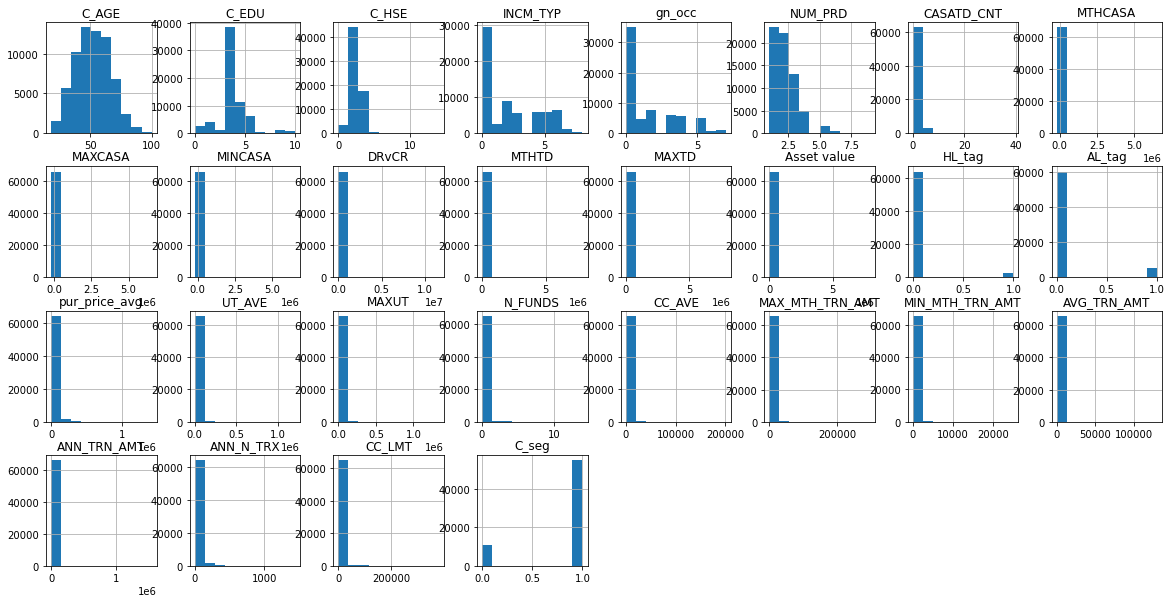

In [70]:
#Histogram Plots
p = df.hist(figsize = (20,10),bins=10,layout=(4,8))

In [ ]:
#Assign Features & Labels
Xdata=df.drop([LABEL_COL],axis=1)
Ydata=df[LABEL_COL]

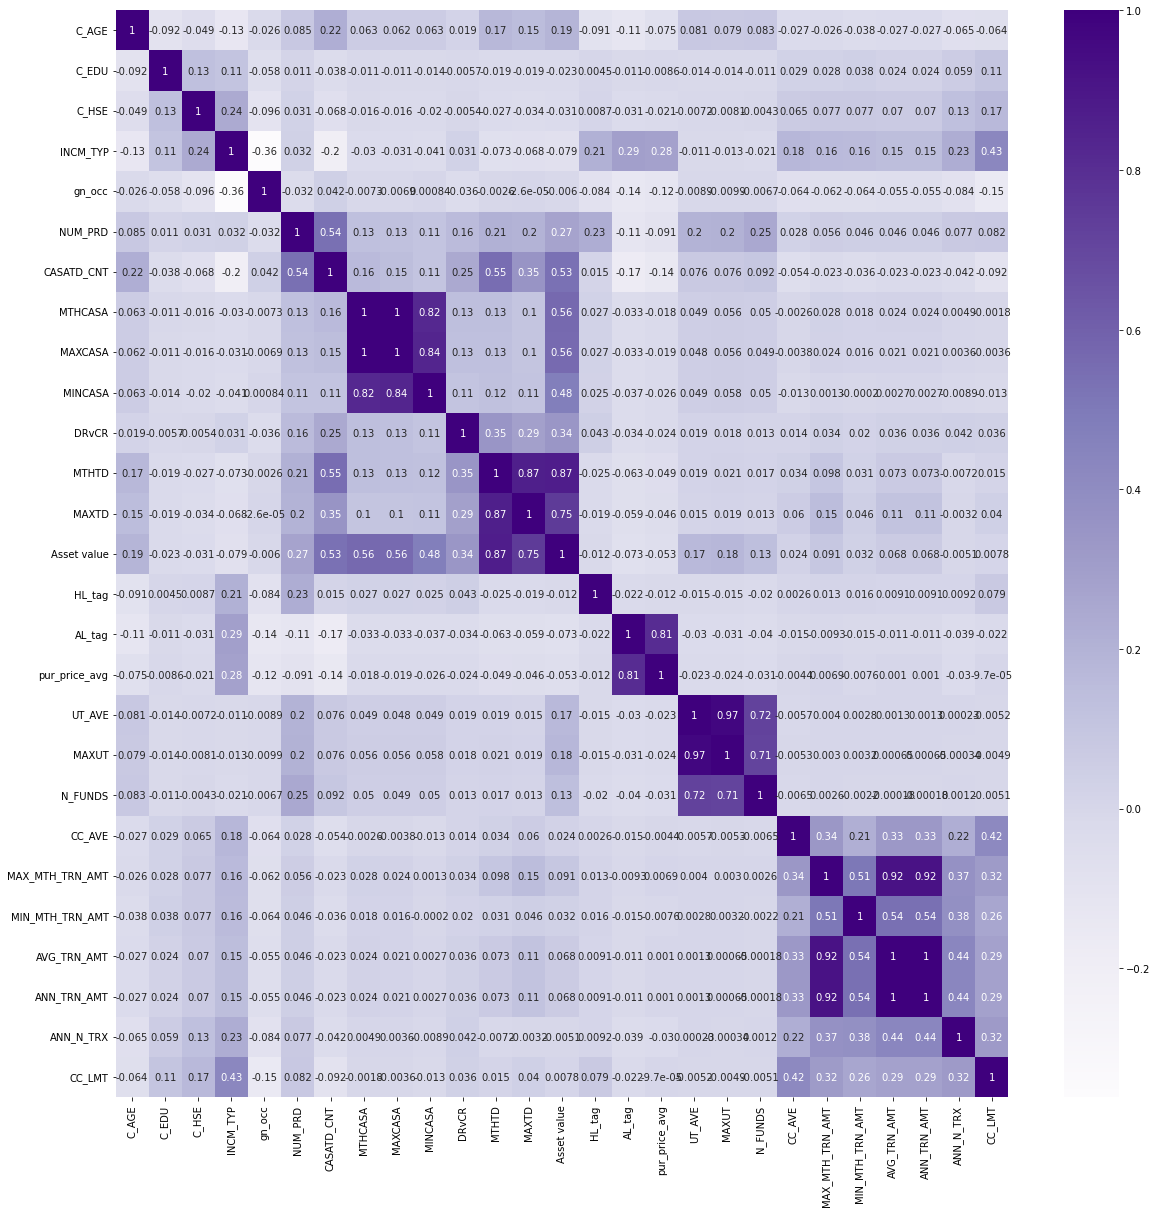

In [79]:
#Correlation Plots
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
g = sns.heatmap(Xdata.corr(),cmap="Purples",annot=True,ax=ax)
#X_train.corr()


***Train Test Split***

In [80]:
#Data Balance for Labels
print('The categories under +',df.groupby(LABEL_COL)[LABEL_COL].count())
print('\n\nThe % of categories are ', df.groupby(LABEL_COL)[LABEL_COL].count()/df[LABEL_COL].count()*100)


The categories under + C_seg
0    10924
1    55039
Name: C_seg, dtype: int64


The % of categories are  C_seg
0    16.560799
1    83.439201
Name: C_seg, dtype: float64


In [81]:
#Split the data into training & testing 

X_train, X_test, y_train, y_test = train_test_split(Xdata,Ydata, test_size=0.2, random_state=0, stratify=Ydata)
print(X_train.shape); print(X_test.shape)

(52770, 27)
(13193, 27)


# URL = 'http://192.168.79.44:5002'
# mlflow.set_tracking_uri(URL)  # Replace with your MLflow server URI

***Decision Tree Classifier (with MLFlow Integration)***

In [82]:
#intialize the decision tree placeholder
clf2 = DecisionTreeClassifier(random_state=9, criterion='gini')  # change it to entropy

#fit the model using training data
clf2 = clf2.fit(X_train, y_train)

# Predict both test and train data 
y_pred_clf_test=clf2.predict(X_test)
y_pred_clf_train=clf2.predict(X_train)

#Score
print("Train Accuracy: {:.3f}".format(clf2.score(X_train, y_train)))
#print(dict(zip(X_train1.columns, clf2.feature_importances_)))
print(classification_report(y_train, y_pred_clf_train))
print("Test Accuracy:",clf2.score(X_test, y_test))
print(classification_report(y_test, y_pred_clf_test))

#uncomment the following if you need a pdf of the tree
#graphvizSave(dt_entropy ,'dt_entropy .pdf')
#graphvizSave(clf2,'clf2.pdf')

Train Accuracy: 0.996
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8739
           1       1.00      1.00      1.00     44031

    accuracy                           1.00     52770
   macro avg       1.00      0.99      0.99     52770
weighted avg       1.00      1.00      1.00     52770

Test Accuracy: 0.8311225649965891
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2185
           1       0.90      0.90      0.90     11008

    accuracy                           0.83     13193
   macro avg       0.69      0.69      0.69     13193
weighted avg       0.83      0.83      0.83     13193



In [76]:
#plot the trees
from sklearn import tree
tree.plot_tree(clf2)

[Text(0.6139158678906919, 0.9871794871794872, 'x[13] <= 37361.314\ngini = 0.276\nsamples = 52770\nvalue = [8739, 44031]'),
 Text(0.3421392805499404, 0.9615384615384616, 'x[13] <= 3874.3\ngini = 0.112\nsamples = 40430\nvalue = [2417, 38013]'),
 Text(0.2389354218747233, 0.9358974358974359, 'x[10] <= 39569.205\ngini = 0.066\nsamples = 31658\nvalue = [1084, 30574]'),
 Text(0.1788524771020213, 0.9102564102564102, 'x[13] <= 1000.1\ngini = 0.056\nsamples = 30663\nvalue = [891, 29772]'),
 Text(0.11055227235161975, 0.8846153846153846, 'x[3] <= 0.5\ngini = 0.043\nsamples = 25009\nvalue = [554, 24455]'),
 Text(0.05759487679817531, 0.8589743589743589, 'x[6] <= 0.5\ngini = 0.071\nsamples = 7099\nvalue = [263, 6836]'),
 Text(0.038512114759590606, 0.8333333333333334, 'x[0] <= 50.5\ngini = 0.104\nsamples = 4162\nvalue = [229, 3933]'),
 Text(0.01535364283917317, 0.8076923076923077, 'x[5] <= 2.5\ngini = 0.054\nsamples = 2210\nvalue = [61, 2149]'),
 Text(0.008599570611735798, 0.782051282051282, 'x[26] <=

Error in callback <function flush_figures at 0x0000025E7112BC10> (for post_execute):


KeyboardInterrupt: 

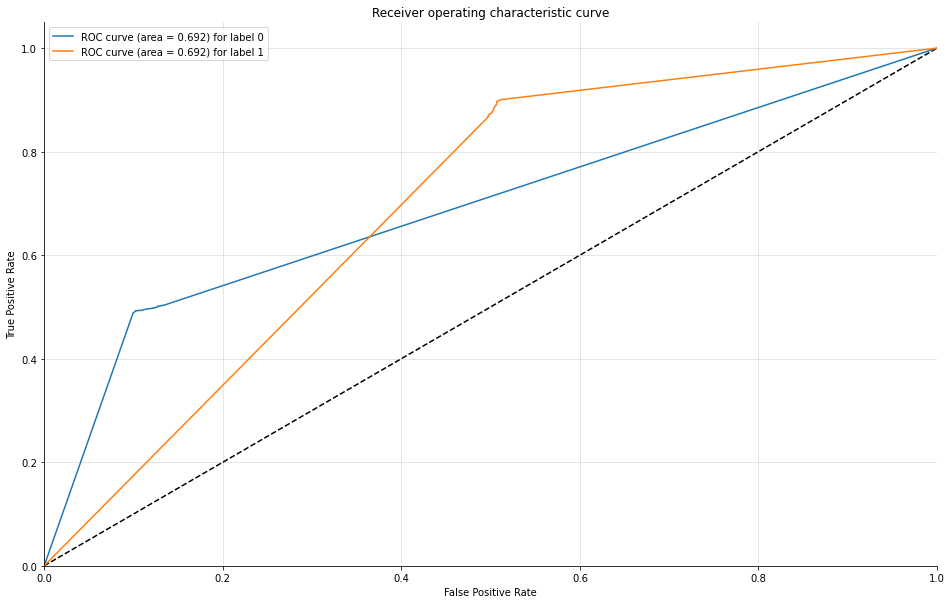

<Figure size 432x288 with 0 Axes>

In [84]:
# Plot ROC_AUC curve to further visualize TP rate vs FP rate
from sklearn.metrics import multilabel_confusion_matrix, roc_auc_score, roc_curve, auc
y_score = clf2.predict_proba(X_test)

n_classes = 2
figsize=(16,10)
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate dummies once
y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# roc for each class
fig, ax = plt.subplots(figsize=figsize)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic curve')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.3f) for label %i' % (roc_auc[i], i))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

pylab.savefig('DT_AUC_ROC_Curve.png')

In [86]:
pd.DataFrame(X_train.columns, clf2.feature_importances_)

,0
0.099972,C_AGE
0.021978,C_EDU
0.015093,C_HSE
0.025788,INCM_TYP
0.032292,gn_occ
0.027972,NUM_PRD
0.016926,CASATD_CNT
0.047911,MTHCASA
0.041068,MAXCASA
0.048692,MINCASA


In [85]:
from sklearn.tree import DecisionTreeClassifier
dt_entropy = DecisionTreeClassifier(criterion='entropy',random_state=10)
dt_entropy.fit(X_train, y_train)
print("Train Accuracy: {:.3f}".format(dt_entropy.score(X_train, y_train)))
print("Test Accuracy: {:.3f}".format(dt_entropy.score(X_test, y_test)))

Train Accuracy: 0.996
Test Accuracy: 0.837


***RandomForest Classifier***

In [98]:
#Initialize the RF
rf_baseline = RandomForestClassifier(n_estimators=300, criterion='gini', random_state=7, ccp_alpha =0)

#Fit the random Forest with training data
rf_baseline.fit(X_train, y_train)

#Predict for both test and train data 
y_pred_baseline_train = rf_baseline.predict(X_train)
y_pred_baseline_test = rf_baseline.predict(X_test)

#get the accuracy scores & classification report
print('Train set Score: ')
print(rf_baseline.score(X_train, y_train))
print('\n')
print('Training Set Classification Report \n')
print(classification_report(y_train, y_pred_baseline_train))
print('Test set Score: ')
print(rf_baseline.score(X_test, y_test))
print('Test Set Classification Report \n')
print(classification_report(y_test, y_pred_baseline_test))

Train set Score: 
0.9959067652075043


Training Set Classification Report 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8739
           1       1.00      1.00      1.00     44031

    accuracy                           1.00     52770
   macro avg       1.00      0.99      0.99     52770
weighted avg       1.00      1.00      1.00     52770

Test set Score: 
0.8771318123247177
Test Set Classification Report 

              precision    recall  f1-score   support

           0       0.67      0.50      0.57      2185
           1       0.91      0.95      0.93     11008

    accuracy                           0.88     13193
   macro avg       0.79      0.73      0.75     13193
weighted avg       0.87      0.88      0.87     13193




 Feature Importances:


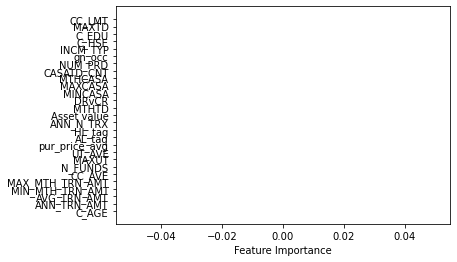

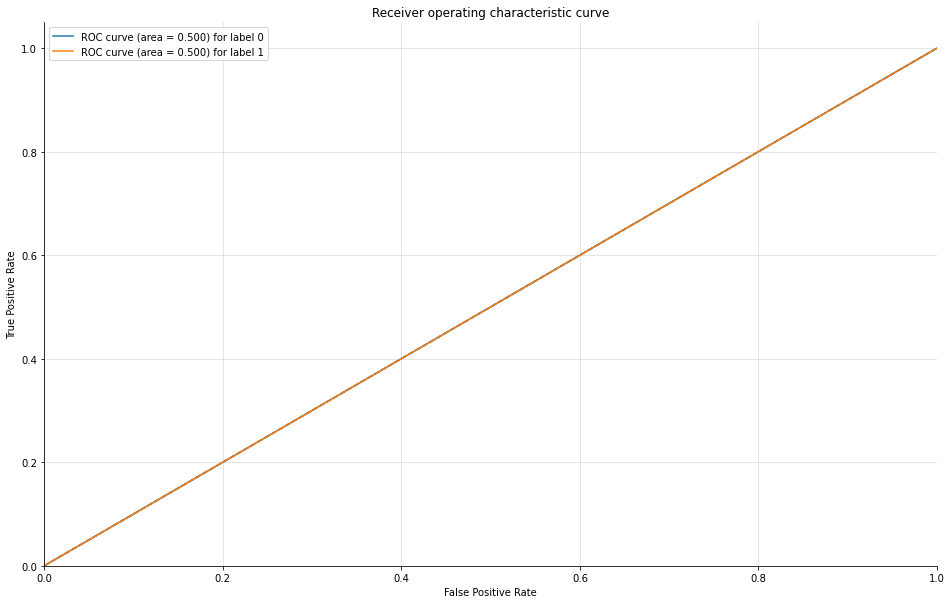

<Figure size 432x288 with 0 Axes>

In [97]:
#Feature Importance
print('\n Feature Importances:')
#print(dict(zip(X_train.columns, rf_baseline.feature_importances_)))
feature_importance = rf_baseline.feature_importances_
sorted_idx = rf_baseline.feature_importances_.argsort()
importances = rf_baseline.feature_importances_[sorted_idx]  # Extract feature importances
plt.barh(Xdata.columns[sorted_idx], importances)
plt.xlabel(f"Feature Importance")
plt.savefig('feature_importance.png', dpi = 500)
feature_importance = dict(zip(Xdata.columns[sorted_idx], importances))

# Plot ROC_AUC curve to further visualize TP rate vs FP rate
from sklearn.metrics import multilabel_confusion_matrix, roc_auc_score, roc_curve, auc
y_score = rf_baseline.predict_proba(X_test)

n_classes = 2
figsize=(16,10)
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate dummies once
y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# roc for each class
fig, ax = plt.subplots(figsize=figsize)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic curve')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.3f) for label %i' % (roc_auc[i], i))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

pylab.savefig('RF_7_Feats_V2_AUC_ROC_Curve.png')